# EEG ChildMind Dataset Analysis

This notebook takes data from ChildMind and finds correlations between neural spectral parameters ratio measures and age.


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
from scipy.stats import pearsonr, spearmanr
import csv
import mne
import seaborn as sns
sns.set_context('poster')
pd.set_option('display.max_columns', 500)

from fooof import FOOOF, FOOOFGroup
from fooof.analysis import *
from fooof.synth import *
from fooof.data import FOOOFResults
from fooof.funcs import average_fg
from fooof.bands import Bands

from ratios import *
from analysis import *
from settings import *

## Import Data

Here we import power spectra and select channel clusters

In [6]:
# Open Power spectrum
data = pd.read_csv("../dat/MIPDB_PublicFile.csv")

In [7]:
# Read in list of channel names that are kept in reduced 111 montage
with open('../dat/chans111.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]
    
# Read montage, reduced to 111 channel selection
montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=ch_labels)

In [8]:
all_chans = mne.pick_channels(montage.ch_names,[])

In [9]:
# Define a channel cluster of interest
ch_cluster_parietal = ['E71', 'E76', 'E70', 'E75', 'E83']
ch_cluster_central = ['E7','E106', 'E31', 'Cz', 'E80']
ch_cluster_frontal = ['E15', 'E18', 'E16', 'E10', 'E11']

# Get the indices of the channels of interest
ch_inds_parietal = mne.pick_channels(montage.ch_names, ch_cluster_parietal)
ch_inds_central = mne.pick_channels(montage.ch_names, ch_cluster_central)
ch_inds_frontal = mne.pick_channels(montage.ch_names, ch_cluster_frontal)

# Correlation between Parameters and Theta Beta Ratio

In [6]:
df = get_all_data(data, all_chans)
df.to_csv("../dat/child_mind_data")
df

KeyboardInterrupt: 

In [10]:
df = pd.read_csv("../dat/child_mind_data")


# All Channels

### All Channels: Exp to Age

In [11]:
all_ch_exp_age_p = pearsonr(df.Exp,df.Age)
all_ch_exp_age_s = spearmanr(df.Exp,df.Age)

print("All Channels exp->age pear:",all_ch_exp_age_p)
print("All Channels exp->age spear:",all_ch_exp_age_s)

All Channels exp->age pear: (-0.5733730602654656, 0.0)
All Channels exp->age spear: SpearmanrResult(correlation=-0.6360477217326502, pvalue=0.0)


### All Channels: TBR to Age

In [12]:
all_ch_tbr_age_p = pearsonr(df.TBR,df.Age)
all_ch_tbr_age_s = spearmanr(df.Exp,df.Age)

print("All Channels tbr->age pear:",all_ch_tbr_age_p)
print("All Channels tbr->age spear:",all_ch_tbr_age_s)

All Channels tbr->age pear: (-0.45598816741837095, 0.0)
All Channels tbr->age spear: SpearmanrResult(correlation=-0.6360477217326502, pvalue=0.0)


# Single Channel
Here we will use Cz (index 94) across all participants

In [19]:
res = peak_param_ratio_corr(df, "TBR", all_chans, func=nan_corr_pearson)
res

array([[ 0.03250524,  0.45373173,  0.15492166],
       [-0.09428855, -0.21386784, -0.05667593]])

In [3]:
# All channel Alpha_Beta and fooof params
def ratio_by_peak_params(ratio, ch=all_chans):
    params = ["Alpha_BW","Alpha_CF","Alpha_PW","Beta_BW", "Beta_CF","Beta_PW","Theta_BW", "Theta_CF","Theta_PW"]
    
    for param in params:
        
        corr = nan_corr_spearman(df[ratio].values, df[param].values)

        print("The corr of {} to {} at {} is {:1.2f}".format(ratio, param, 'Cz', corr[1]))

ratio_by_peak_params("ABR")

NameError: name 'all_chans' is not defined

In [4]:
# Data Settings
cur_channel = "94"
cur_ratio = 'TAR'

In [39]:
#DataFrame which only has Cz channels
df_ch = df.loc[df['Chan_ID'] == cur_channel]

cz_exp = df.Exp.values.astype(float)
cz_age = df.Age.values.astype(float)
cz_ratio = df[cur_ratio].values.astype(float)

### CZ: Exp to Age

In [43]:
print("The corr of {} to {} at {} is {:1.2f}, {:1.2f}".format('TAR', 'EXP', 'Cz', 0.500000000001, 0.01))

The corr of TAR to EXP at Cz is 0.50, 0.01


In [34]:
cz_exp_age_p = pearsonr(cz_exp, cz_age)
cz_exp_age_s = spearmanr(cz_exp, cz_age)

print("Cz exp->age pear:", cz_exp_age_p)
print("Cz exp->age spear:", cz_exp_age_s)

Cz exp->age pear: (-0.5733730602654656, 0.0)
Cz exp->age spear: SpearmanrResult(correlation=-0.6360477217326502, pvalue=0.0)


### CZ: TBR to Age

In [35]:
cz_tar_age_p = pearsonr(cz_tar, cz_age)
cz_tar_age_s = spearmanr(cz_tar, cz_age)

print("Cz tbr->age pear:", cz_tar_age_p)
print("Cz tbr->age spear:", cz_tar_age_s)

Cz tbr->age pear: (-0.2062977954036027, 4.920804533483743e-103)
Cz tbr->age spear: SpearmanrResult(correlation=-0.3128364612419722, pvalue=3.111147788583773e-241)


In [6]:
all_age_parietal = get_real_params(data, ch_inds_parietal)
all_age_central = get_real_params(data, ch_inds_central)
all_age_frontal = get_real_params(data, ch_inds_frontal)

###################

all_age_parietal_tb_ratio = all_age_parietal[0][0]
all_age_parietal_apc = all_age_parietal[0][1]

all_age_central_tb_ratio = all_age_central[0][0]
all_age_central_apc = all_age_central[0][1]

all_age_frontal_tb_ratio = all_age_frontal[0][0]
all_age_frontal_apc = all_age_frontal[0][1]

###################

all_age_parietal_pearson = pearsonr(all_age_parietal_apc, all_age_parietal_tb_ratio)
all_age_parietal_spearman = spearmanr(all_age_parietal_apc, all_age_parietal_tb_ratio)

all_age_central_pearson = pearsonr(all_age_central_apc, all_age_central_tb_ratio)
all_age_central_spearman = spearmanr(all_age_central_apc, all_age_central_tb_ratio)

all_age_frontal_pearson = pearsonr(all_age_frontal_apc, all_age_frontal_tb_ratio)
all_age_frontal_spearman = spearmanr(all_age_frontal_apc, all_age_frontal_tb_ratio)

NameError: name 'get_real_params' is not defined

# Peak param correlations below

In [5]:
all_age_parietal_fg = get_real_fg(data, ch_inds_parietal)
all_age_central_fg = get_real_fg(data, ch_inds_central)
all_age_frontal_fg = get_real_fg(data, ch_inds_frontal)

NameError: name 'ch_inds_parietal' is not defined

In [ ]:
for ind, val in enumerate(all_age_parietal_fg[0]):
    theta_cf_parietal.append(all_age_parietal_fg[0][ind].peak_params_[0][0])
    beta_cf_parietal.append(all_age_parietal_fg[0][ind].peak_params_[1][0])
    theta_amp_parietal.append(all_age_parietal_fg[0][ind].peak_params_[0][1])
    beta_amp_parietal.append(all_age_parietal_fg[0][ind].peak_params_[1][1])
    theta_bw_parietal.append(all_age_parietal_fg[0][ind].peak_params_[0][2])
    beta_bw_parietal.append(all_age_parietal_fg[0][ind].peak_params_[1][2])
    
    theta_cf_central.append(all_age_central_fg[0][ind].peak_params_[0][0])
    beta_cf_central.append(all_age_central_fg[0][ind].peak_params_[1][0])
    theta_amp_central.append(all_age_central_fg[0][ind].peak_params_[0][1])
    beta_amp_central.append(all_age_central_fg[0][ind].peak_params_[1][1])
    theta_bw_central.append(all_age_central_fg[0][ind].peak_params_[0][2])
    beta_bw_central.append(all_age_central_fg[0][ind].peak_params_[1][2])
    
    theta_cf_frontal.append(all_age_frontal_fg[0][ind].peak_params_[0][0])
    beta_cf_frontal.append(all_age_frontal_fg[0][ind].peak_params_[1][0])
    theta_amp_frontal.append(all_age_frontal_fg[0][ind].peak_params_[0][1])
    beta_amp_frontal.append(all_age_frontal_fg[0][ind].peak_params_[1][1])
    theta_bw_frontal.append(all_age_frontal_fg[0][ind].peak_params_[0][2])
    beta_bw_frontal.append(all_age_frontal_fg[0][ind].peak_params_[1][2])
avg_tb_ratios = all_age_parietal_fg[1]

In [106]:
# Theta CF Parietal
parietal_t_cf_pear = nan_corr_p(theta_cf_parietal, avg_tb_ratios)
parietal_t_cf_spear = nan_corr_s(theta_cf_parietal, avg_tb_ratios)

# Beta CF Parietal
parietal_b_cf_pear = nan_corr_p(beta_cf_parietal, avg_tb_ratios)
parietal_b_cf_spear = nan_corr_s(beta_cf_parietal, avg_tb_ratios)

#Theta amp parietal
parietal_t_amp_pear = nan_corr_p(theta_amp_parietal, avg_tb_ratios)
parietal_t_amp_spear = nan_corr_s(theta_amp_parietal, avg_tb_ratios)

# beta amp parietal
parietal_b_amp_pear = nan_corr_p(beta_amp_parietal, avg_tb_ratios)
parietal_b_amp_spear = nan_corr_s(beta_amp_parietal, avg_tb_ratios)

#theta bw parietal
parietal_t_bw_pear = nan_corr_p(theta_bw_parietal, avg_tb_ratios)
parietal_t_bw_spear = nan_corr_s(theta_bw_parietal, avg_tb_ratios)

#beta bw parietal
parietal_b_bw_pear = nan_corr_p(beta_bw_parietal, avg_tb_ratios)
parietal_b_bw_spear = nan_corr_s(beta_bw_parietal, avg_tb_ratios)

################################################

# Theta CF central
central_t_cf_pear = nan_corr_p(theta_cf_central, avg_tb_ratios)
central_t_cf_spear = nan_corr_s(theta_cf_central, avg_tb_ratios)

# Beta CF Parietal
central_b_cf_pear = nan_corr_p(beta_cf_central, avg_tb_ratios)
central_b_cf_spear = nan_corr_s(beta_cf_central, avg_tb_ratios)

#Theta amp parietal
central_t_amp_pear = nan_corr_p(theta_amp_central, avg_tb_ratios)
central_t_amp_spear = nan_corr_s(theta_amp_central, avg_tb_ratios)

# beta amp parietal
central_b_amp_pear = nan_corr_p(beta_amp_central, avg_tb_ratios)
central_b_amp_spear = nan_corr_s(beta_amp_central, avg_tb_ratios)

#theta bw parietal
central_t_bw_pear = nan_corr_p(theta_bw_central, avg_tb_ratios)
central_t_bw_spear = nan_corr_s(theta_bw_central, avg_tb_ratios)

#beta bw parietal
central_b_bw_pear = nan_corr_p(beta_bw_central, avg_tb_ratios)
central_b_bw_spear = nan_corr_s(beta_bw_central, avg_tb_ratios)

################################################
# Theta CF central
frontal_t_cf_pear = nan_corr_p(theta_cf_frontal, avg_tb_ratios)
frontal_t_cf_spear = nan_corr_s(theta_cf_frontal, avg_tb_ratios)

# Beta CF Parietal
frontal_b_cf_pear = nan_corr_p(beta_cf_frontal, avg_tb_ratios)
frontal_b_cf_spear = nan_corr_s(beta_cf_frontal, avg_tb_ratios)

#Theta amp parietal
frontal_t_amp_pear = nan_corr_p(theta_amp_frontal, avg_tb_ratios)
frontal_t_amp_spear = nan_corr_s(theta_amp_frontal, avg_tb_ratios)

# beta amp parietal
frontal_b_amp_pear = nan_corr_p(beta_amp_frontal, avg_tb_ratios)
frontal_b_amp_spear = nan_corr_s(beta_amp_frontal, avg_tb_ratios)

#theta bw parietal
frontal_t_bw_pear = nan_corr_p(theta_bw_frontal, avg_tb_ratios)
frontal_t_bw_spear = nan_corr_s(theta_bw_frontal, avg_tb_ratios)

#beta bw parietal
frontal_b_bw_pear = nan_corr_p(beta_bw_frontal, avg_tb_ratios)
frontal_b_bw_spear = nan_corr_s(beta_bw_frontal, avg_tb_ratios)

In [140]:
print("central theta cf spearman: " ,central_t_cf_spear)
print("central theta amp spearman: " ,central_t_amp_spear)
print("central theta bw spearman: " ,central_t_bw_spear)

print("central beta cf spearman: " ,central_b_cf_spear)
print("central beta amp spearman: " ,central_b_amp_spear)
print("central beta bw spearman: " ,central_b_bw_spear)
theta_data = [central_t_cf_spear[0],central_t_amp_spear[0], central_t_bw_spear[0]]
beta_data = [central_b_cf_spear[0],central_b_amp_spear[0], central_b_bw_spear[0]]
heats = np.array([theta_data, beta_data])

central theta cf spearman:  SpearmanrResult(correlation=-0.0002908483921142149, pvalue=0.9979835636736129)
central theta amp spearman:  SpearmanrResult(correlation=0.2869409071940717, pvalue=0.010862745523717)
central theta bw spearman:  SpearmanrResult(correlation=0.25806904209266446, pvalue=0.022536902721927647)
central beta cf spearman:  SpearmanrResult(correlation=0.03506995581737849, pvalue=0.7330837766115756)
central beta amp spearman:  SpearmanrResult(correlation=-0.27132863454660217, pvalue=0.0071825001951504736)
central beta bw spearman:  SpearmanrResult(correlation=-0.1242837559303342, pvalue=0.22517042716138022)


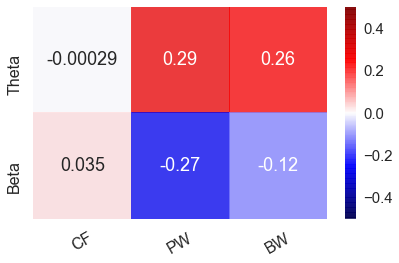

In [188]:

fig, ax = plt.subplots()


# We want to show all ticks...

# ... and label them with the respective list entries

ax.set_yticklabels(["theta", "beta"])

sns.set(font_scale=1.5)

sns.heatmap(heats, vmin=-.5,vmax=.5,annot=True, cmap= "seismic", xticklabels=["CF", "PW", "BW"], yticklabels=["Theta","Beta"], alpha=.75)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("../figures/spectral_features_corr_to_TBR.png", dpi=700)

## Aperiodic stuff below

In [39]:
# Exponenent


# Peak Params
#fm_parietal = avg_fg(all_age_parietal_fg[0])
#fm_central = avg_fg(all_age_central_fg[0])
#fm_frontal = avg_fg(all_age_frontal_fg[0])

In [ ]:


print("All subjects parietal pearson: ", all_age_parietal_pearson)
print("All subjects parietal spearman: ", all_age_parietal_spearman)
print(" ")

print("All subjects central pearson: ", all_age_central_pearson)
print("All subjects central spearman: ", all_age_central_spearman)
print(" ")

print("All subjects frontal pearson: ", all_age_frontal_pearson)
print("All subjects frontal spearman: ", all_age_frontal_spearman)
print(" ")

## Predicting age from exponent

In [45]:
all_age_parietal_exp_age_p = pearsonr(all_age_parietal_apc, all_age_parietal[0][3])
all_age_parietal_exp_age_s = spearmanr(all_age_parietal_apc, all_age_parietal[0][3])

all_age_frontal_exp_age_p = pearsonr(all_age_frontal_apc, all_age_frontal[0][3])
all_age_frontal_exp_age_s = spearmanr(all_age_frontal_apc, all_age_frontal[0][3])

all_age_central_exp_age_p = pearsonr(all_age_central_apc, all_age_central[0][3])
all_age_central_exp_age_s = spearmanr(all_age_central_apc, all_age_central[0][3])

print("parietal exponent correlates to age (pearson): ", all_age_parietal_exp_age_p)
print("parietal exponent correlates to age (spearman): ", all_age_parietal_exp_age_s)
print()

print("frontal exponent correlates to age (pearson): ", all_age_frontal_exp_age_p)
print("frontal exponent correlates to age (spearman): ", all_age_frontal_exp_age_s)
print()

print("central exponent correlates to age (pearson): ", all_age_central_exp_age_p)
print("central exponent correlates to age (spearman): ", all_age_central_exp_age_s)

parietal exponent correlates to age (pearson):  (-0.6346683381968523, 4.876675414400836e-56)
parietal exponent correlates to age (spearman):  SpearmanrResult(correlation=-0.6872611745253143, pvalue=4.704989892502931e-69)

frontal exponent correlates to age (pearson):  (-0.5763808342149647, 2.7991407815194255e-44)
frontal exponent correlates to age (spearman):  SpearmanrResult(correlation=-0.6682322088698998, pvalue=4.8991535403989085e-64)

central exponent correlates to age (pearson):  (-0.5224239758370124, 2.5732584232546035e-35)
central exponent correlates to age (spearman):  SpearmanrResult(correlation=-0.6214873474536138, pvalue=3.6765509885372348e-53)


## Predicting Age from TBR

In [47]:
all_age_parietal_tbr_age_p = pearsonr(all_age_parietal_tb_ratio, all_age_parietal[0][3])
all_age_parietal_tbr_age_s = spearmanr(all_age_parietal_tb_ratio, all_age_parietal[0][3])

all_age_frontal_tbr_age_p = pearsonr(all_age_frontal_tb_ratio, all_age_frontal[0][3])
all_age_frontal_tbr_age_s = spearmanr(all_age_frontal_tb_ratio, all_age_frontal[0][3])

all_age_central_tbr_age_p = pearsonr(all_age_central_tb_ratio, all_age_central[0][3])
all_age_central_tbr_age_s = spearmanr(all_age_central_tb_ratio, all_age_central[0][3])

print("parietal exponent correlates to age (pearson): ", all_age_parietal_tbr_age_p)
print("parietal exponent correlates to age (spearman): ", all_age_parietal_tbr_age_s)
print()

print("frontal exponent correlates to age (pearson): ", all_age_frontal_tbr_age_p)
print("frontal exponent correlates to age (spearman): ", all_age_frontal_tbr_age_s)
print()

print("central exponent correlates to age (pearson): ", all_age_central_tbr_age_p)
print("central exponent correlates to age (spearman): ", all_age_central_tbr_age_s)

parietal exponent correlates to age (pearson):  (-0.4670253733105622, 1.206598334508968e-27)
parietal exponent correlates to age (spearman):  SpearmanrResult(correlation=-0.6367548776477613, pvalue=1.6586917847631905e-56)

frontal exponent correlates to age (pearson):  (-0.4465835155636714, 3.7701086519872125e-25)
frontal exponent correlates to age (spearman):  SpearmanrResult(correlation=-0.5833603215560321, pvalue=1.454751633682585e-45)

central exponent correlates to age (pearson):  (-0.48649966838431596, 3.4930650277180965e-30)
central exponent correlates to age (spearman):  SpearmanrResult(correlation=-0.6507169948479196, pvalue=9.782106424394115e-60)
